# Towards Subject-Agnostic Prediction of Neural Activity in the Primary Visual Cortex Using Meta-Learning

In [1]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras import layers, models, losses, optimizers
import os
from tensorflow.keras.models import Model
import time
import datetime
np.random.seed(42)
tf.random.set_seed(45)
from IPython import display
import random
import keras

## 16 Neuron MAML

In [4]:
data_path = "data/"
data1 = sio.loadmat(data_path+'01mean50ms_smallim_d2_crop.mat')
data2 = sio.loadmat(data_path+'02mean50ms_smallim_d2_crop.mat')
data3 = sio.loadmat(data_path+'03mean50ms_smallim_d2_crop.mat')
data4 = sio.loadmat(data_path+'04mean50ms_smallim_d2_crop.mat')
data5 = sio.loadmat(data_path+'05mean50ms_smallim_d2_crop.mat')
data6 = sio.loadmat(data_path+'06mean50ms_smallim_d2_crop.mat')
data7 = sio.loadmat(data_path+'07mean50ms_smallim_d2_crop.mat')
data8 = sio.loadmat(data_path+'08mean50ms_smallim_d2_crop.mat')
data9 = sio.loadmat(data_path+'09mean50ms_smallim_d2_crop.mat')
data10 = sio.loadmat(data_path+'10mean50ms_smallim_d2_crop.mat')

### Defining a Task Class

In [3]:
class Train_Task:
    def __init__(self, x_train, y_train, x_test, y_test, n_neurons,  batch_size=216):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.n_neurons = n_neurons
        self.batch_size = batch_size

    def train_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_train)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_train, batch_indices)
        batch_y = tf.gather(self.y_train, batch_indices)
        #return tf.expand_dims(batch_x, axis=3), batch_y
        return tf.expand_dims(self.x_train, axis=3), self.y_train
        #return self.x_train[:3], self.y_train[:3]

    def test_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_test)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_test, batch_indices)
        batch_y = tf.gather(self.y_test, batch_indices)
        #return tf.expand_dims(batch_x, axis=3), batch_y
        return tf.expand_dims(self.x_test, axis=3), self.y_test
        #return self.x_test, self.y_test

class Test_Task:
    def __init__(self, x_ft, y_ft, x_test, y_test, n_neurons, batch_size):
        self.x_ft = x_ft
        self.y_ft = y_ft
        self.x_test = x_test
        self.y_test = y_test
        self.n_neurons = n_neurons
        self.batch_size = batch_size

### Preparing the Data

In [5]:
def clip(matrix, length=16):
    m = len(matrix[0])
    start_index = random.randint(0, m-length)
    return matrix[:, start_index:start_index+length]
clip(data10["activity"]).shape

(270, 16)

In [5]:
import numpy as np
a = np.array([1,1,1])
b = 2*a
c = a
set([a,b,c])

TypeError: unhashable type: 'numpy.ndarray'

In [10]:
all(a==c)

True

In [11]:
2*[1,2,4]

[1, 2, 4, 1, 2, 4]

In [15]:
a = [0,1,2]
b = [2*x for x in a]
c = a
set([1,2,1,3])

{1, 2, 3}

In [17]:
all([x==y for x,y in zip(a,c)])

True

In [18]:
l = [a,b,c]
a in l

True

In [14]:
def create_train_task(data_dict):
    X = data_dict["images"][:, 1:, 1:]/255.0
    y = clip(data_dict["activity"])
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
    train_task = Train_Task(X_train, y_train, X_test, y_test, n_neurons=y.shape[1])
    return train_task

def create_test_task(data_dict, bs=10):
    X = data_dict["images"][:, 1:, 1:]/255.0
    y = clip(data_dict["activity"])
    # Generate shuffled indices
    shuffled_indices = np.random.permutation(len(X))

    # Shuffle both X and y using the shuffled indices
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    X = X_shuffled
    y = y_shuffled
    x_ft = X[:bs]
    y_ft = y[:bs]
    x_test = X[bs:]
    y_test = y[bs:]
    test_task = Test_Task(x_ft,y_ft,x_test,y_test, y.shape[1],bs)
    return test_task

data_dics = [data1, data2, data3, data4, data5, data7, data8, data9, data10]
training_set = [create_train_task(data_dic) for data_dic in data_dics]
test_task = create_test_task(data6)

In [15]:
training_set[1].train_batch()[1].shape

(216, 16)

In [16]:
# Generic CNN predictor class
class V1_Predictor(tf.keras.Model):
    def __init__(self, output_units=16):
        super().__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, 3, activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(20, activation='relu')
        self.out = layers.Dense(output_units, activation='relu')

    def forward(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        output = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

    def call(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        output = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

### Useful Functions

In [17]:
def loss_function2(pred_y, y, n_neurons):
  return tf.keras.losses.mse(y[:n_neurons], pred_y[:n_neurons])

def loss_function(pred_y, y):
  return tf.keras.losses.mse(y, pred_y)

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model(x)
    mse = loss_fn(y, logits)
    return mse

def compute_loss2(model, x, y, n_neurons, loss_fn=loss_function2):
    logits = model(x)
    mse = loss_fn(y, logits, n_neurons)
    return mse


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))


def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss

In [18]:
def copy_model(model, x):
    '''
    Copy model weights to a new model.

    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = V1_Predictor()
    copied_model.forward(x)
    copied_model.set_weights(model.get_weights())

    return copied_model

### Meta-Learning Training Function

In [19]:
def maml_train(model, dataset, epochs, num_inner_steps, inner_lr=0.0001):
    losses = []  # List to store the losses for plotting

    # Best values: inner_lr=0.0001 and outer_lr =0.001
    outer_lr = 0.0005
    optimizer = tf.keras.optimizers.Adam(outer_lr)
    # Meta-training loop
    init  = tf.constant(1.0, shape=(1,33,33,1))
    model(init)
    for epoch in range(epochs):
        meta_losses = []  # List to store the meta-losses for the current meta-iteration

        # Iterate over training tasks
        sum_test_losses = 0.0
        for task in dataset:

            # Create a copy of the meta-model for the inner loop
            inner_model = copy_model(model,init)
            # Sample a batch of data from the task
            x_train, y_train = task.train_batch()
            # Inner loop: Adaptation on the task
            for _ in range(num_inner_steps):
                #
                # Compute the loss on the batch
                with tf.GradientTape() as inner_tape:
                    train_loss = compute_loss(inner_model, x_train, y_train)
                inner_gradients = inner_tape.gradient(train_loss, inner_model.trainable_variables)
                k = 0
                ### Upating weights only for the trainable layers
                for j in range(len(inner_model.layers)):
                    if len(inner_model.layers[j].get_weights()) > 0:
                        weights = inner_model.layers[j].get_weights()
                        weights[0] = tf.subtract(weights[0], tf.multiply(inner_lr, inner_gradients[k]))
                        weights[1] = tf.subtract(weights[1], tf.multiply(inner_lr, inner_gradients[k+1]))
                        inner_model.layers[j].set_weights(weights)
                        k += 2
            x_test, y_test = task.test_batch()
            with tf.GradientTape() as meta_tape:
                test_loss = compute_loss(inner_model, x_test, y_test)
                # Accumulate test loss
                sum_test_losses += test_loss

            # Compute the gradients for the meta-model update
            meta_gradients = meta_tape.gradient(sum_test_losses, inner_model.trainable_variables)

            # Apply the meta-gradients to update the meta-model
            optimizer.apply_gradients(zip(meta_gradients, model.trainable_variables))
            meta_losses.append(test_loss)

        # Calculate the mean loss for the meta-iteration
        mean_loss = tf.reduce_mean(meta_losses)
        losses.append(mean_loss)
        print("Iteration {} - Loss: {:.2f}".format(epoch+1, losses[-1].numpy()))
        #Early stopping, patience = 5 epochs
        if len(losses) > 5:
          if all(losses[-1] >= loss for loss in losses[-6:-1]):
              print("No improvement in 2 epochs, stopping training.")
              break

        # Perform any desired evaluation or logging
    return losses

### Training the MAML Model

In [20]:
maml = V1_Predictor()
Losses = maml_train(maml, training_set, epochs=20, num_inner_steps= 10)
plt.figure(figsize=(10,6))
plt.xlabel('Epochs')
plt.ylabel('Meta Learner Loss')
plt.title('Loss vs Epochs')
plt.plot(Losses)
plt.show()

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [216,6,6,16] vs. [216,16] [Op:Sub] name: 

In [16]:
Losses[-1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.39461494465965286>

### Testing the MAML Model

In [17]:
def test_maml(meta_model, test_task):
    # Create a copy of the meta-model for the inner loop
    #init  = tf.constant(1.0, shape=(1,33,33,1))
    #inner_model = copy_model(meta_model, init)
    # Inner loop: Adaptation on the test task
    print("Batch size:", test_task.batch_size)
    test_model = tf.keras.Sequential([
                meta_model,
                layers.Flatten(),
                layers.Dense(test_task.n_neurons+4, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(test_task.n_neurons, activation='relu')
            ])
    num_inner_steps = 15
    optimizer = tf.keras.optimizers.Adam(0.0001)
    # Sample a batch of data from the test task
    x_train, y_train = test_task.x_ft, test_task.y_ft
    x_train = tf.expand_dims(x_train, axis=3)
    for _ in range(num_inner_steps):

        # Compute the loss on the batch
        with tf.GradientTape() as fine_tune_tape:
            fine_tune_loss  = compute_loss(test_model, x_train, y_train)
        inner_gradients = fine_tune_tape.gradient(fine_tune_loss, test_model.trainable_variables)

        # Update the inner model parameters
        #optimizer.apply_gradients(zip(inner_gradients, test_model.trainable_variables))

    # Evaluate the adapted model on the test set of the task
    x_test, y_test = test_task.x_test, test_task.y_test
    x_test = tf.expand_dims(x_test, axis=3)
    test_loss = compute_loss(test_model, x_test, y_test)

    # Print or return the evaluation results
    print("Test Loss:", tf.reduce_mean(test_loss).numpy())
    return test_model
# Test the trained MAML model on the new task
test_model = test_maml(maml, test_task)

Batch size: 10
Test Loss: 1.2661189955221195


In [ ]:
init  = tf.constant(1.0, shape=(1,33,33,1))
test_model(init)
test_model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['mse'])
test_model.fit(test_task.x_ft, test_task.y_ft,
               epochs= 15,
               batch_size=1)

### Plotting Actual vs Predicted Activations

In [18]:
X6 = data6["images"]/ 255.0
y6 = data6["activity"]

In [19]:
def concat(data_list):
    """
    Function to bundle all the data from the first 9 experimental sessions into a single
    dictionary. The shape of the activations matrix will be (270,316)
    """
    images = data_list[0]["images"]
    activity = data_list[0]["activity"]
    for data_dict in data_list[1:]:
        activity = np.concatenate((activity, data_dict["activity"]), axis=1)
    return dict({"images":images, "activity":activity})

def concat1(data_list):
    """
    Function to bundle all the data from the first 9 experimental sessions into a single
    dictionary. The shape of the activations matrix will be (270,316)
    """
    images = data_list[0]["images"]
    activity = data_list[0]["activity"][:, :16]
    for data_dict in data_list[1:]:
        activity = np.concatenate((activity, data_dict["activity"][:, :16]), axis=1)
    return dict({"images":images, "activity":activity})
data_list1 = [data1, data2, data3, data4, data5, data7, data8, data9, data10]
data_list2 = [data1, data2, data3, data4, data5, data6, data7, data8, data9]
data_list3 = [data1, data3, data4, data5, data6, data7, data8, data9, data10]
clipped_data = concat1(data_list1)
data = concat(data_list1)
#X = data["images"] [:, 1:, 1:]/255.0
X = data["images"]/255.0
y = data["activity"]
#y_shuffled = np.random.permutation(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [20]:
#X = data["images"] [:, 1:, 1:]/255.0
X = clipped_data["images"]/255.0
y = clipped_data["activity"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
# Defining the CNN model
model = tf.keras.Sequential()

# Adding the convolutional layers
model.add(layers.Input(shape=(33, 33, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model.add(layers.Flatten())

# Adding the fully connected layers
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='relu'))

# Compiling the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
history = model.fit(X_train, y_train,
                    epochs=70,
                    validation_data=(X_test, y_test))

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.6027 - mse: 0.6027 - val_loss: 0.3367 - val_mse: 0.3367
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3769 - mse: 0.3769 - val_loss: 0.2416 - val_mse: 0.2416
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2888 - mse: 0.2888 - val_loss: 0.2024 - val_mse: 0.2024
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2273 - mse: 0.2273 - val_loss: 0.1795 - val_mse: 0.1795
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.2040 - mse: 0.2040 - val_loss: 0.1596 - val_mse: 0.1596
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1894 - mse: 0.1894 - val_loss: 0.1532 - val_mse: 0.1532
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1774 - mse: 0.1774 - val_loss: 0.1490 - val_mse: 0.1490
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1657 - mse: 0.1657 - val_loss: 0.1463 - val_mse: 0.1463
Epoch 9/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1586 - mse: 0.1586 - 

In [21]:
# Defining the CNN model
model3 = tf.keras.Sequential()

# Adding the convolutional layers
model3.add(layers.Input(shape=(33, 33, 1)))
model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model3.add(layers.Flatten())

# Adding the fully connected layers
model3.add(layers.Dense(20, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(data6["activity"].shape[1], activation='relu'))

# Copying the trained model's weights into the new model's
model3.set_weights(model.get_weights()[:4]+model3.get_weights()[4:])

# Freezing all the layers except for the last one
#for layer in model3.layers[:-2]:
    #layer.trainable = False

#Compiling the model
model3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [22]:
init  = tf.constant(1.0, shape=(1,33,33,1))
test_model(init)
test_model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['mse'])
test_model.fit(test_task.x_ft, test_task.y_ft,
               epochs= 5,
               batch_size=1)

Epoch 1/5


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9891 - mse: 0.9891 
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7131 - mse: 0.7131 
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7749 - mse: 0.7749 
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6784 - mse: 0.6784 
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5986 - mse: 0.5986


In [23]:
history3 = model3.fit(test_task.x_ft, test_task.y_ft,
                    epochs=5,
                    batch_size=1
                    )

Epoch 1/5


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1377 - mse: 1.1377
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8912 - mse: 0.8912 
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7910 - mse: 0.7910 
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7842 - mse: 0.7842 
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7257 - mse: 0.7257 


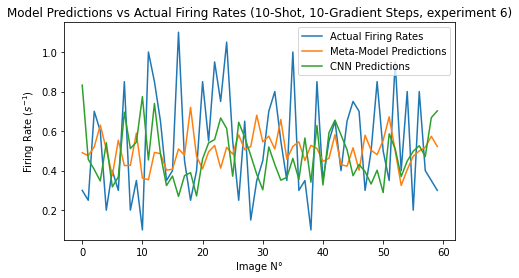

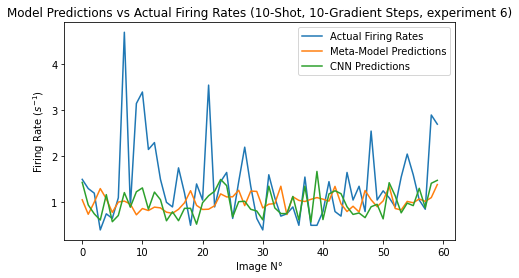

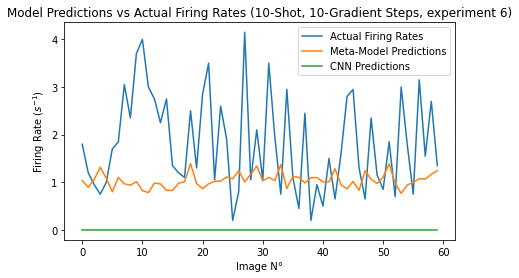

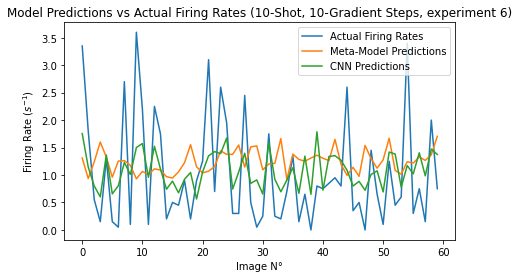

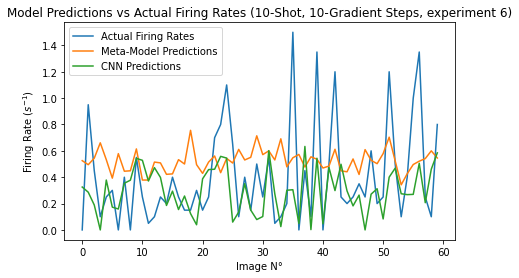

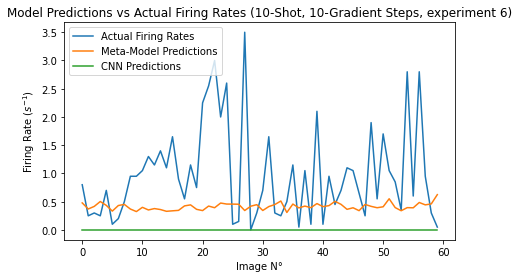

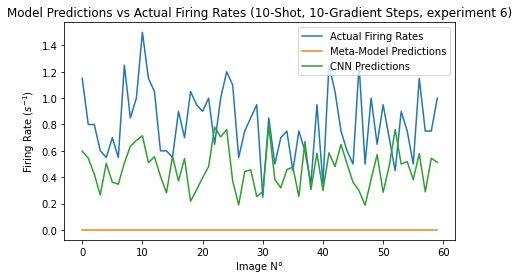

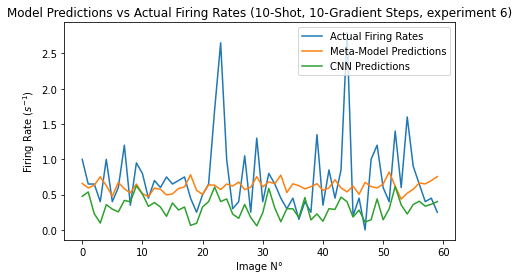

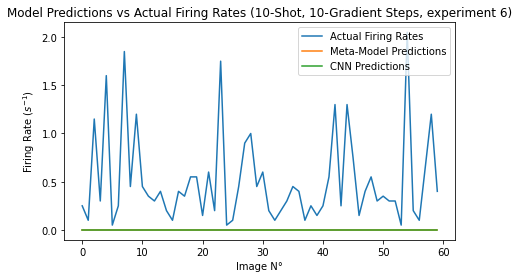

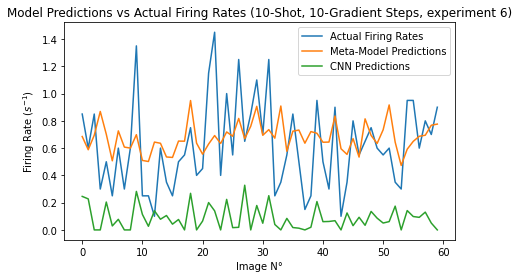

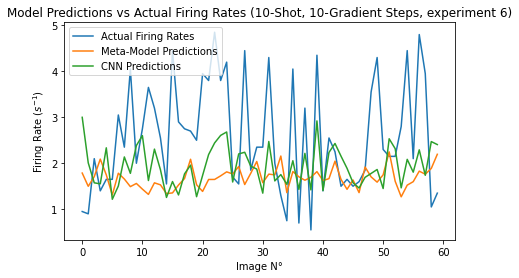

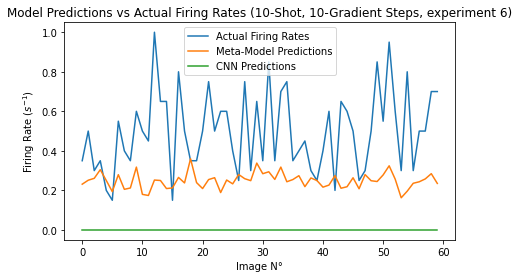

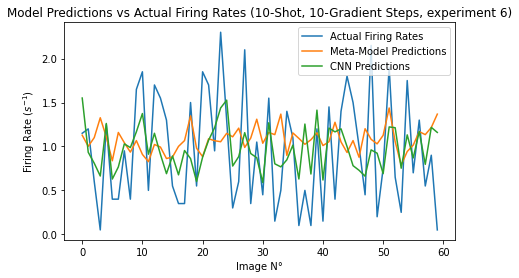

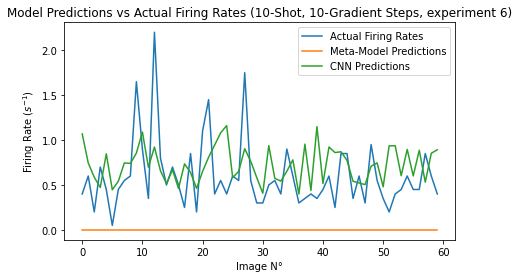

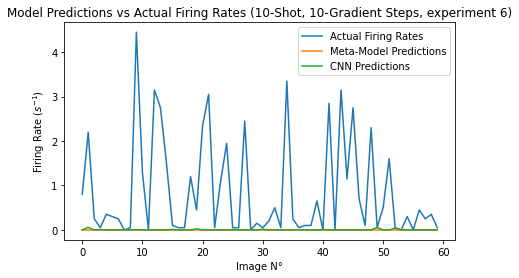

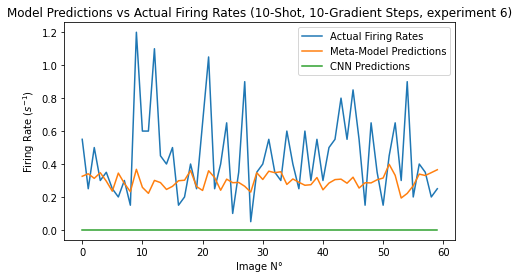

In [24]:
for i in range(16):
    index = np.random.choice(range(test_task.y_test.shape[1]))
    xt = np.expand_dims(test_task.x_test, axis=3)
    yt = test_task.y_test
    y_preds = test_model(xt)[:,i]
    y_preds_cnn = model3(xt)[:,i]
    plt.figure(figsize=(7,4))
    # Plotting the actual activations
    #plt.plot(range(len(yt)), yt[:,i], label='Actual Activations')
    plt.plot(range(60), yt[:60,i], label='Actual Firing Rates')

    # Plotting the predicted activations for the meta-model
    plt.plot(range(60), y_preds[:60], label='Meta-Model Predictions')

    # Plotting the predicted activations for the CNN
    plt.plot(range(60), y_preds_cnn[:60], label='CNN Predictions')

    plt.xlabel('Image N°')
    plt.ylabel('Firing Rate ($s^{-1}$)')
    plt.title('Model Predictions vs Actual Firing Rates (10-Shot, 10-Gradient Steps, experiment 6)')
    plt.legend()

    plt.show()

### Correlation

In [25]:
def compute_correlation(y_preds, y):
    corrs = []
    for i in range(y.shape[1]):
        corrs.append(np.corrcoef(y_preds[:,i], y[:,i])[0, 1])
    print(len(corrs))
    return np.nanmean(corrs)
x_test = np.expand_dims(test_task.x_test, axis=3)
y_preds = test_model.predict(x_test)
correlation = compute_correlation(y_preds, test_task.y_test)
print("Correlation coefficient:", correlation)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
16
Correlation coefficient: -0.12783796835426173


/home/student23/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/student23/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 44- Neuron MAML

### Task Class

In [ ]:
class Train_Task2:
    def __init__(self, x_train, y_train, x_test, y_test, n_neurons, batch_size=9):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.n_neurons = n_neurons
        self.batch_size = batch_size

    def train_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_train)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_train, batch_indices)
        batch_y = tf.gather(self.y_train, batch_indices)
        #return tf.expand_dims(batch_x, axis=3), batch_y
        return tf.expand_dims(self.x_train, axis=3), self.y_train
        #return self.x_train[:3], self.y_train[:3]

    def test_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_test)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_test, batch_indices)
        batch_y = tf.gather(self.y_test, batch_indices)
        #return tf.expand_dims(batch_x, axis=3), batch_y
        return tf.expand_dims(self.x_test, axis=3), self.y_test
        #return self.x_test, self.y_test

class Test_Task2:
    def __init__(self, x_ft, y_ft, x_test, y_test, n_neurons, batch_size=9):
        self.x_ft = x_ft
        self.y_ft = y_ft
        self.x_test = x_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.n_neurons = n_neurons

### Meta-Model Class

In [ ]:
# Generic CNN predictor class
class V1_Predictor2(tf.keras.Model):
    def __init__(self, output_units=44):
        super().__init__()
        self.output_units = output_units
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu',)
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(output_units, activation='relu')

    def forward(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

    def call(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

    #def assign(self, model)
     #   self.set_weights(model.get_weights())

### Useful Functions

In [ ]:
def copy_model1(model, n_neurons):
    copied_model = V1_Predictor2(output_units=n_neurons)
    init  = tf.constant(1.0, shape=(1,33,33,1))
    copied_model(init)
    copied_model.set_weights(model.get_weights())
    return copied_model

def copy_model2(model, n_neurons, x):
    '''
    Copy model weights to a new model.

    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = V1_Predictor2(output_units=n_neurons)
    copied_model(x)
    copied_model.set_weights(model.get_weights()[:-2]+copied_model.get_weights()[6:])

    return copied_model

def copy_model3(model, x):

    copied_model = V1_Predictor2()
    copied_model.forward(x)
    copied_model.set_weights(model.get_weights())

    return copied_model
def copy_common_layers(source_model, target_model):
    target_model.set_weights(source_model.get_weights()[:-2]+target_model.get_weights()[6:])
    return target_model

def merge_layers(stump_model, tree_model):
    new_model = V1_Predictor2(tree_model.output_units)
    init  = tf.constant(1.0, shape=(1,33,33,1))
    new_model(init)
    new_model.set_weights(stump_model.get_weights()[:-2]+tree_model.get_weights()[6:])
    return new_model

In [ ]:
def adjust(vector, length=44):
    if len(vector)>=length:
      return vector[:length]
    else:
      padded_vector = []
      m = len(vector)
      for i in range(length):
          padded_vector.append(vector[i%m])
      return np.array(padded_vector)

def adjust_vectors(vectors, length=44):
    adjusted_vectors = []
    for vector in vectors:
        adjusted_vectors.append(adjust(vector,length))
    return np.array(adjusted_vectors)

def create_train_task2(data_dict):
    X = data_dict["images"]/255.0
    y = adjust_vectors(data_dict["activity"])
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
    train_task = Train_Task2(X_train, y_train, X_test, y_test, n_neurons=data_dict['activity'].shape[1])
    return train_task

def create_test_task2(data_dict, bs=10):
    X = data_dict["images"]/255.0
    y = adjust_vectors(data_dict["activity"])
    # Generate shuffled indices
    shuffled_indices = np.random.permutation(len(X))

    # Shuffle both X and y using the shuffled indices
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    X = X_shuffled
    y = y_shuffled
    x_ft = X[:bs]
    y_ft = y[:bs]
    x_test = X[bs:]
    y_test = y[bs:]
    test_task = Test_Task2(x_ft,y_ft,x_test,y_test, n_neurons=data_dict['activity'].shape[1], batch_size=bs)
    return test_task

data_dics = [data1, data2, data3, data4, data5, data6, data7, data8, data9]
training_set2 = [create_train_task2(data_dic) for data_dic in data_dics]
test_task2 = create_test_task2(data10)

In [ ]:
for task in training_set2:
    print(task.n_neurons)

26
37
34
28
44
16
36
66
29


In [ ]:
for task in training_set2:
    print(task.y_train.shape[1])

44
44
44
44
44
44
44
44
44


In [ ]:
training_set2[0].train_batch()[0].shape

TensorShape([216, 33, 33, 1])

### Meta Learning Function

In [ ]:
def maml_train2(model, dataset, epochs, num_inner_steps, inner_lr=0.0001):
    losses = []  # List to store the losses for plotting

    # Best values: inner_lr=0.0001 and outer_lr =0.001
    outer_lr = 0.0005
    optimizer = tf.keras.optimizers.Adam(outer_lr)
    # Meta-training loop
    init  = tf.constant(1.0, shape=(1,33,33,1))
    model(init)
    for epoch in range(epochs):
        meta_losses = []  # List to store the meta-losses for the current meta-iteration

        # Iterate over training tasks
        sum_test_losses = 0.0
        for task in dataset:

            # Create a copy of the meta-model for the inner loop
            inner_model = copy_model3(model,init)
            # Sample a batch of data from the task
            x_train, y_train = task.train_batch()
            # Inner loop: Adaptation on the task
            for _ in range(num_inner_steps):
                #
                # Compute the loss on the batch
                with tf.GradientTape() as inner_tape:
                    train_loss = compute_loss2(inner_model, x_train, y_train, task.n_neurons)
                inner_gradients = inner_tape.gradient(train_loss, inner_model.trainable_variables)
                k = 0
                ### Upating weights only for the trainable layers
                for j in range(len(inner_model.layers)):
                    if len(inner_model.layers[j].get_weights()) > 0:
                        weights = inner_model.layers[j].get_weights()
                        weights[0] = tf.subtract(weights[0], tf.multiply(inner_lr, inner_gradients[k]))
                        weights[1] = tf.subtract(weights[1], tf.multiply(inner_lr, inner_gradients[k+1]))
                        inner_model.layers[j].set_weights(weights)
                        k += 2
            x_test, y_test = task.test_batch()
            with tf.GradientTape() as meta_tape:
                test_loss = compute_loss(inner_model, x_test, y_test)
                # Accumulate test loss
                sum_test_losses += test_loss

            # Compute the gradients for the meta-model update
            meta_gradients = meta_tape.gradient(sum_test_losses, inner_model.trainable_variables)

            # Apply the meta-gradients to update the meta-model
            optimizer.apply_gradients(zip(meta_gradients, model.trainable_variables))
            meta_losses.append(test_loss)

        # Calculate the mean loss for the meta-iteration
        mean_loss = tf.reduce_mean(meta_losses)
        losses.append(mean_loss)
        print("Iteration {} - Loss: {:.2f}".format(epoch+1, losses[-1].numpy()))
        #Early stopping, patience = 3 epochs
        if len(losses) > 3:
          if all(losses[-1] >= loss for loss in losses[-3:-1]):
              print("No improvement in 2 epochs, stopping training.")
              break

        # Perform any desired evaluation or logging
    return losses

### Training the MAML

Iteration 1 - Loss: 0.62
Iteration 2 - Loss: 0.54
Iteration 3 - Loss: 0.52
Iteration 4 - Loss: 0.50
Iteration 5 - Loss: 0.49
Iteration 6 - Loss: 0.48
Iteration 7 - Loss: 0.47
Iteration 8 - Loss: 0.46
Iteration 9 - Loss: 0.45
Iteration 10 - Loss: 0.45
Iteration 11 - Loss: 0.45
Iteration 12 - Loss: 0.44
Iteration 13 - Loss: 0.44
Iteration 14 - Loss: 0.44
Iteration 15 - Loss: 0.43
Iteration 16 - Loss: 0.43
Iteration 17 - Loss: 0.43
Iteration 18 - Loss: 0.43
Iteration 19 - Loss: 0.43
Iteration 20 - Loss: 0.43
Iteration 21 - Loss: 0.42
Iteration 22 - Loss: 0.42
Iteration 23 - Loss: 0.42
Iteration 24 - Loss: 0.42
Iteration 25 - Loss: 0.42
Iteration 26 - Loss: 0.42
Iteration 27 - Loss: 0.41
Iteration 28 - Loss: 0.41
Iteration 29 - Loss: 0.41
Iteration 30 - Loss: 0.41


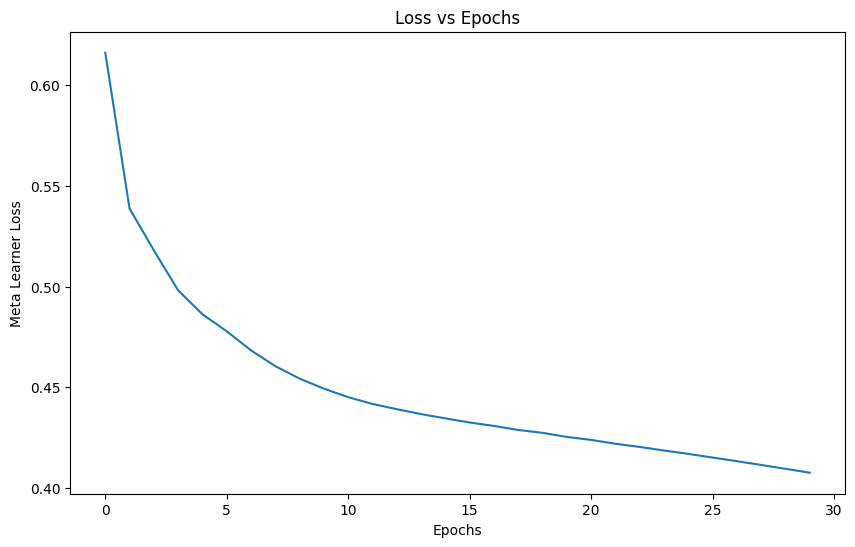

In [ ]:
maml2 = V1_Predictor2()
Losses2 = maml_train2(maml2, training_set2, epochs=30, num_inner_steps=10)
plt.figure(figsize=(10,6))
plt.xlabel('Epochs')
plt.ylabel('Meta Learner Loss')
plt.title('Loss vs Epochs')
plt.plot(Losses2)
plt.show()

In [ ]:
Losses2[-1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.4076563712351382>

### Testing the MAML

In [ ]:
def test_maml2(meta_model, test_task):

    # Inner loop: Adaptation on the test task
    print(test_task.batch_size)
    num_inner_steps = 15
    optimizer = tf.keras.optimizers.Adam(0.0001)
    # Sample a batch of data from the test task
    x_train, y_train = test_task.x_ft, test_task.y_ft
    x_train = tf.expand_dims(x_train, axis=3)
    for inner_step in range(num_inner_steps):

        # Compute the loss on the batch
        with tf.GradientTape() as inner_tape:
            inner_loss = compute_loss2(meta_model, x_train, y_train, test_task.n_neurons)
        inner_gradients = inner_tape.gradient(inner_loss, meta_model.trainable_variables)

        # Update the inner model parameters
        optimizer.apply_gradients(zip(inner_gradients, meta_model.trainable_variables))

    # Evaluate the adapted model on the test set of the task
    x_test, y_test = test_task.x_test, test_task.y_test
    x_test = tf.expand_dims(x_test, axis=3)
    test_loss = compute_loss(meta_model, x_test, y_test)

    # Print or return the evaluation results
    print("Test Loss:", tf.reduce_mean(test_loss).numpy())

# Test the trained MAML model on the new task
test_maml2(maml2, test_task2)

10
Test Loss: 0.581266626950014


### CTCNN

In [ ]:
def concat(data_list):
    """
    Function to bundle all the data from the first 9 experimental sessions into a single
    dictionary. The shape of the activations matrix will be (270,316)
    """
    images = data_list[0]["images"]
    activity = adjust_vectors(data_list[0]["activity"])
    for data_dict in data_list[1:]:
        activity = np.concatenate((activity, adjust_vectors(data_dict["activity"])), axis=1)
    return dict({"images":images, "activity":activity})

data_list = [data1, data2, data3, data4, data6, data7, data8, data9, data10]
adj_data = concat(data_list)

In [ ]:
adj_data["activity"].shape

(270, 396)

In [ ]:
data5["activity"].shape

(270, 44)

In [ ]:
y.shape[1]

396

In [ ]:
X = adj_data["images"]/255.0
y = adj_data["activity"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
y_train.shape
X5 = data5["images"]/ 255.0
y5 = data5["activity"]
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5,y5,test_size=0.2, random_state=42)


# Defining the CNN model
model4 = tf.keras.Sequential()

# Adding the convolutional layers
model4.add(layers.Input(shape=(33, 33, 1)))
model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model4.add(layers.Flatten())

# Adding the fully connected layers
model4.add(layers.Dense(400, activation='relu'))
model4.add(tf.keras.layers.Dense(y.shape[1], activation='relu'))
# Compiling the model
model4.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
history = model4.fit(X_train, y_train,
                    epochs=60,
                    validation_data=(X_test, y_test))

Epoch 1/60
7/7 [==============================] - 2s 55ms/step - loss: 0.5974 - mse: 0.5974 - val_loss: 0.3945 - val_mse: 0.3945
Epoch 2/60
7/7 [==============================] - 0s 18ms/step - loss: 0.3730 - mse: 0.3730 - val_loss: 0.3125 - val_mse: 0.3125
Epoch 3/60
7/7 [==============================] - 0s 15ms/step - loss: 0.3077 - mse: 0.3077 - val_loss: 0.2705 - val_mse: 0.2705
Epoch 4/60
7/7 [==============================] - 0s 16ms/step - loss: 0.2682 - mse: 0.2682 - val_loss: 0.2508 - val_mse: 0.2508
Epoch 5/60
7/7 [==============================] - 0s 16ms/step - loss: 0.2567 - mse: 0.2567 - val_loss: 0.2512 - val_mse: 0.2512
Epoch 6/60
7/7 [==============================] - 0s 15ms/step - loss: 0.2524 - mse: 0.2524 - val_loss: 0.2409 - val_mse: 0.2409
Epoch 7/60
7/7 [==============================] - 0s 15ms/step - loss: 0.2426 - mse: 0.2426 - val_loss: 0.2281 - val_mse: 0.2281
Epoch 8/60
7/7 [==============================] - 0s 13ms/step - loss: 0.2290 - mse: 0.2290 - val

In [ ]:
# Fine-Tuning the Model
## Defining the CNN model
model5 = tf.keras.Sequential()

# Adding the convolutional layers
model5.add(layers.Input(shape=(33, 33, 1)))
model5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model5.add(layers.Flatten())

# Adding the fully connected layers
model5.add(layers.Dense(400, activation='relu'))
model5.add(tf.keras.layers.Dense(data5["activity"].shape[1], activation='relu'))

# Compiling the model
model5.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
# Copying the trained model's weights into the new model's
model5.set_weights(model4.get_weights()[:-4]+model5.get_weights()[4:])

# Freezing all the layers except for the last one
#for layer in model5.layers[:-2]:
    #layer.trainable = False

#Compiling the model
model5.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

# Generate shuffled indices
shuffled_indices = np.random.permutation(len(X5))

# Shuffle both X and y using the shuffled indices
X5_shuffled = X5[shuffled_indices]
y5_shuffled = y5[shuffled_indices]
X5 = X5_shuffled
y5 = y5_shuffled
X_train5 = X5[:10]
X_test5 = X5[10:]
y_train5 = y5[:10]
y_test5 = y5[10:]
history = model5.fit(X_train5, y_train5,
                    epochs=15,
                    validation_data=(X_test5, y_test5))

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 0.4270 - mse: 0.4270 - val_loss: 0.3552 - val_mse: 0.3552
Epoch 2/15
1/1 [==============================] - 0s 109ms/step - loss: 0.2976 - mse: 0.2976 - val_loss: 0.3362 - val_mse: 0.3362
Epoch 3/15
1/1 [==============================] - 0s 54ms/step - loss: 0.2672 - mse: 0.2672 - val_loss: 0.2973 - val_mse: 0.2973
Epoch 4/15
1/1 [==============================] - 0s 50ms/step - loss: 0.2184 - mse: 0.2184 - val_loss: 0.2862 - val_mse: 0.2862
Epoch 5/15
1/1 [==============================] - 0s 51ms/step - loss: 0.2049 - mse: 0.2049 - val_loss: 0.2873 - val_mse: 0.2873
Epoch 6/15
1/1 [==============================] - 0s 59ms/step - loss: 0.2073 - mse: 0.2073 - val_loss: 0.2791 - val_mse: 0.2791
Epoch 7/15
1/1 [==============================] - 0s 53ms/step - loss: 0.1952 - mse: 0.1952 - val_loss: 0.2617 - val_mse: 0.2617
Epoch 8/15
1/1 [==============================] - 0s 53ms/step - loss: 0.1696 - mse: 0.1696 - val_

### Plotting Actual vs Predicted Firing Rates

9/9 [==============================] - 0s 2ms/step


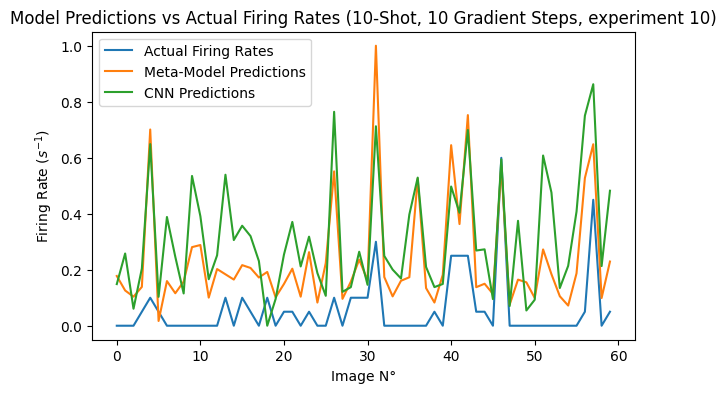

9/9 [==============================] - 0s 2ms/step


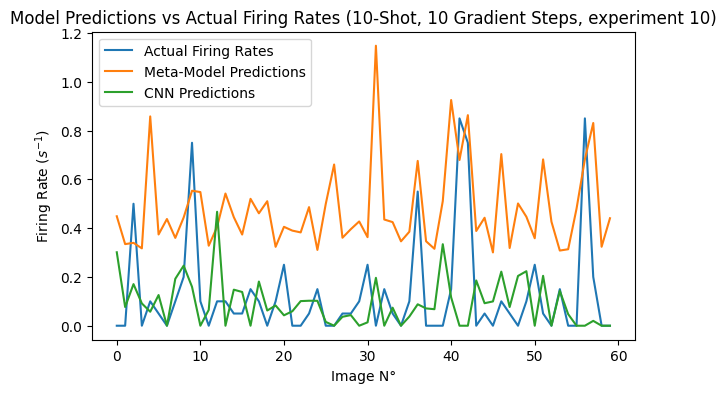

9/9 [==============================] - 0s 2ms/step


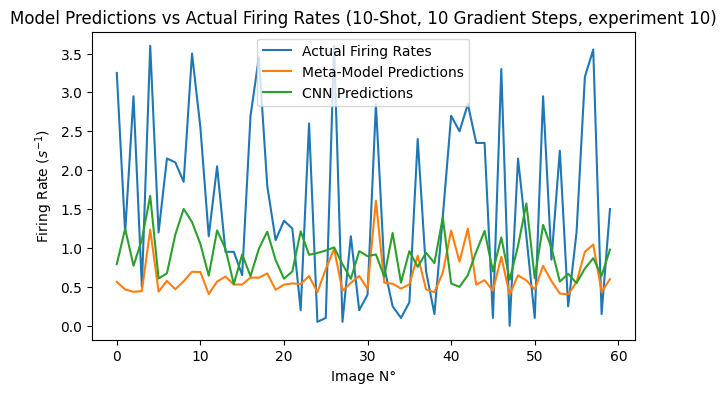

9/9 [==============================] - 0s 2ms/step


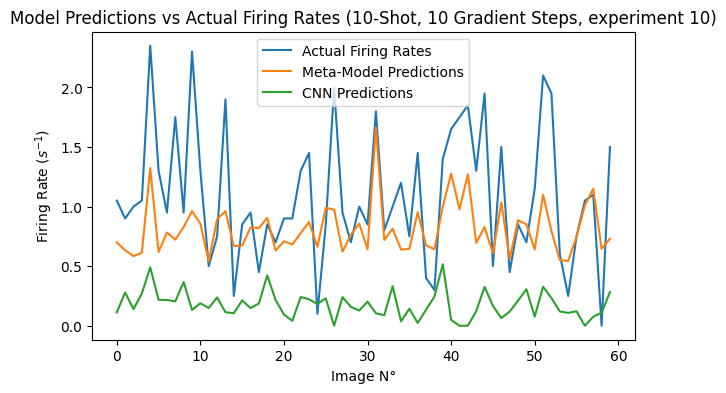

9/9 [==============================] - 0s 2ms/step


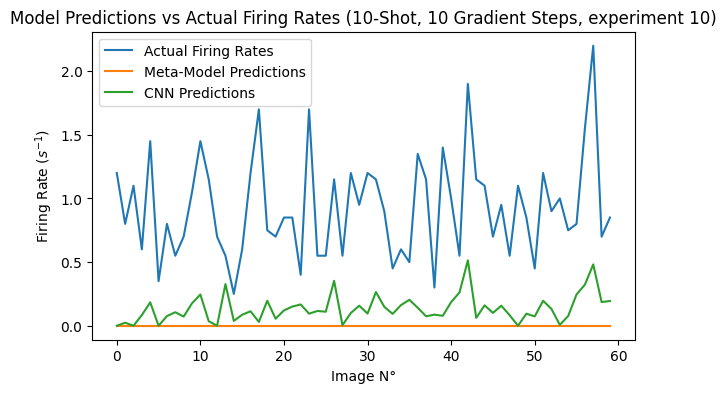

In [ ]:
for i in range(5):
    index = np.random.choice(range(test_task2.y_test.shape[1]))
    xt = np.expand_dims(test_task2.x_test, axis=3)
    yt = test_task2.y_test
    y_preds = maml2.predict(xt)[:,i]
    y_preds_cnn = model5.predict(xt)[:,i]
    plt.figure(figsize=(7,4))
    # Plotting the actual activations
    plt.plot(range(60), yt[:60,i], label='Actual Firing Rates')

    # Plotting the predicted activations for the meta-model
    plt.plot(range(60), y_preds[:60], label='Meta-Model Predictions')

    # Plotting the predicted activations for the CNN
    plt.plot(range(60), y_preds_cnn[:60], label='CNN Predictions')

    plt.xlabel('Image N°')
    plt.ylabel('Firing Rate ($s^{-1}$)')
    plt.title('Model Predictions vs Actual Firing Rates (10-Shot, 10 Gradient Steps, experiment 10)')
    plt.legend()

    plt.show()

### Correlation

In [ ]:
def compute_correlation(y_preds, y):
    corrs = []
    for i in range(y.shape[1]):
        corrs.append(np.corrcoef(y_preds[:,i], y[:,i])[0, 1])
    print(len(corrs))
    return np.nanmean(corrs)
x_test = np.expand_dims(test_task2.x_test, axis=3)
y_preds = model5.predict(x_test)
correlation = compute_correlation(y_preds, test_task2.y_test)
print("Correlation coefficient:", correlation)

9/9 [==============================] - 0s 2ms/step
44
Correlation coefficient: 0.08385415516232873


## 76-Neuron MAML

### Defining a Task Class

In [ ]:
class Train_Task2:
    def __init__(self, x_train, y_train, x_test, y_test, n_neurons, batch_size=9):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.n_neurons = n_neurons
        self.batch_size = batch_size

    def train_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_train)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_train, batch_indices)
        batch_y = tf.gather(self.y_train, batch_indices)
        #return tf.expand_dims(batch_x, axis=3), batch_y
        return tf.expand_dims(self.x_train, axis=3), self.y_train
        #return self.x_train[:3], self.y_train[:3]

    def test_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_test)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_test, batch_indices)
        batch_y = tf.gather(self.y_test, batch_indices)
        #return tf.expand_dims(batch_x, axis=3), batch_y
        return tf.expand_dims(self.x_test, axis=3), self.y_test
        #return self.x_test, self.y_test

class Test_Task2:
    def __init__(self, x_ft, y_ft, x_test, y_test, n_neurons, batch_size=9):
        self.x_ft = x_ft
        self.y_ft = y_ft
        self.x_test = x_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.n_neurons = n_neurons

In [ ]:
# Generic CNN predictor class
class V1_Predictor2(tf.keras.Model):
    def __init__(self, output_units=76):
        super().__init__()
        self.output_units = output_units
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu',)
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(80, activation='relu')
        self.out = layers.Dense(output_units, activation='relu')

    def forward(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

    def call(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

    #def assign(self, model)
     #   self.set_weights(model.get_weights())

In [ ]:
def copy_model1(model, n_neurons):
    copied_model = V1_Predictor2(output_units=n_neurons)
    init  = tf.constant(1.0, shape=(1,33,33,1))
    copied_model(init)
    copied_model.set_weights(model.get_weights())
    return copied_model

def copy_model2(model, n_neurons, x):
    '''
    Copy model weights to a new model.

    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = V1_Predictor2(output_units=n_neurons)
    copied_model(x)
    copied_model.set_weights(model.get_weights()[:-2]+copied_model.get_weights()[6:])

    return copied_model

def copy_model3(model, x):

    copied_model = V1_Predictor2()
    copied_model.forward(x)
    copied_model.set_weights(model.get_weights())

    return copied_model
def copy_common_layers(source_model, target_model):
    target_model.set_weights(source_model.get_weights()[:-2]+target_model.get_weights()[6:])
    return target_model

def merge_layers(stump_model, tree_model):
    new_model = V1_Predictor2(tree_model.output_units)
    init  = tf.constant(1.0, shape=(1,33,33,1))
    new_model(init)
    new_model.set_weights(stump_model.get_weights()[:-2]+tree_model.get_weights()[6:])
    return new_model

In [ ]:
def pad(vector, length=76):
    padded_vector = []
    m = len(vector)
    for i in range(length):
        padded_vector.append(vector[i%m])
    return np.array(padded_vector)

def pad_vectors(vectors, length=76):
    padded_vectors = []
    for vector in vectors:
        padded_vectors.append(pad(vector,length))
    return np.abs(padded_vectors)

def create_train_task2(data_dict, bs=5):
    X = data_dict["images"]/255.0
    y = pad_vectors(data_dict["activity"])
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
    train_task = Train_Task2(X_train, y_train, X_test, y_test, n_neurons=data_dict['activity'].shape[1])
    return train_task

def create_test_task2(data_dict, bs=10):
    X = data_dict["images"]/255.0
    y = pad_vectors(data_dict["activity"])
    # Generate shuffled indices
    shuffled_indices = np.random.permutation(len(X))

    # Shuffle both X and y using the shuffled indices
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    X = X_shuffled
    y = y_shuffled
    x_ft = X[:bs]
    y_ft = y[:bs]
    x_test = X[bs:]
    y_test = y[bs:]
    test_task = Test_Task2(x_ft,y_ft,x_test,y_test, n_neurons=data_dict['activity'].shape[1], batch_size=bs)
    return test_task

data_dics = [data1, data2, data3, data4, data5, data6, data7, data8, data9]
training_set2 = [create_train_task2(data_dic) for data_dic in data_dics]
test_task2 = create_test_task2(data10)

In [ ]:
for task in training_set2:
    print(task.n_neurons)

26
37
34
28
44
16
36
66
29


In [ ]:
for task in training_set2:
    print(task.y_train.shape[1])

76
76
76
76
76
76
76
76
76


In [ ]:
test_task2.y_ft.shape[1]

76

### Meta-Learning Training Function 2

In [ ]:
def maml_train2(model, dataset, epochs, num_inner_steps, inner_lr=0.0001):
    losses = []  # List to store the losses for plotting

    # Best values: inner_lr=0.0001 and outer_lr =0.001
    outer_lr = 0.0005
    optimizer = tf.keras.optimizers.Adam(outer_lr)
    # Meta-training loop
    init  = tf.constant(1.0, shape=(1,33,33,1))
    model(init)
    for epoch in range(epochs):
        meta_losses = []  # List to store the meta-losses for the current meta-iteration

        # Iterate over training tasks
        sum_test_losses = 0.0
        for task in dataset:

            # Create a copy of the meta-model for the inner loop
            inner_model = copy_model3(model,init)
            # Sample a batch of data from the task
            x_train, y_train = task.train_batch()
            # Inner loop: Adaptation on the task
            for _ in range(num_inner_steps):
                #
                # Compute the loss on the batch
                with tf.GradientTape() as inner_tape:
                    train_loss = compute_loss2(inner_model, x_train, y_train, task.n_neurons)
                inner_gradients = inner_tape.gradient(train_loss, inner_model.trainable_variables)
                k = 0
                ### Upating weights only for the trainable layers
                for j in range(len(inner_model.layers)):
                    if len(inner_model.layers[j].get_weights()) > 0:
                        weights = inner_model.layers[j].get_weights()
                        weights[0] = tf.subtract(weights[0], tf.multiply(inner_lr, inner_gradients[k]))
                        weights[1] = tf.subtract(weights[1], tf.multiply(inner_lr, inner_gradients[k+1]))
                        inner_model.layers[j].set_weights(weights)
                        k += 2
            x_test, y_test = task.test_batch()
            with tf.GradientTape() as meta_tape:
                test_loss = compute_loss(inner_model, x_test, y_test)
                # Accumulate test loss
                sum_test_losses += test_loss

            # Compute the gradients for the meta-model update
            meta_gradients = meta_tape.gradient(sum_test_losses, inner_model.trainable_variables)

            # Apply the meta-gradients to update the meta-model
            optimizer.apply_gradients(zip(meta_gradients, model.trainable_variables))
            meta_losses.append(test_loss)

        # Calculate the mean loss for the meta-iteration
        mean_loss = tf.reduce_mean(meta_losses)
        losses.append(mean_loss)
        print("Iteration {} - Loss: {:.2f}".format(epoch+1, losses[-1].numpy()))
        #Early stopping, patience = 3 epochs
        if len(losses) > 3:
          if all(losses[-1] >= loss for loss in losses[-3:-1]):
              print("No improvement in 2 epochs, stopping training.")
              break

        # Perform any desired evaluation or logging
    return losses

Iteration 1 - Loss: 0.67
Iteration 2 - Loss: 0.59
Iteration 3 - Loss: 0.55
Iteration 4 - Loss: 0.53
Iteration 5 - Loss: 0.51
Iteration 6 - Loss: 0.50
Iteration 7 - Loss: 0.49
Iteration 8 - Loss: 0.48
Iteration 9 - Loss: 0.47
Iteration 10 - Loss: 0.47
Iteration 11 - Loss: 0.47
Iteration 12 - Loss: 0.46
Iteration 13 - Loss: 0.46
Iteration 14 - Loss: 0.46
Iteration 15 - Loss: 0.46
Iteration 16 - Loss: 0.46
Iteration 17 - Loss: 0.45
Iteration 18 - Loss: 0.45
Iteration 19 - Loss: 0.45
Iteration 20 - Loss: 0.45
Iteration 21 - Loss: 0.45
Iteration 22 - Loss: 0.45
Iteration 23 - Loss: 0.45
Iteration 24 - Loss: 0.45
Iteration 25 - Loss: 0.44
Iteration 26 - Loss: 0.44
Iteration 27 - Loss: 0.44
Iteration 28 - Loss: 0.43
Iteration 29 - Loss: 0.43
Iteration 30 - Loss: 0.43


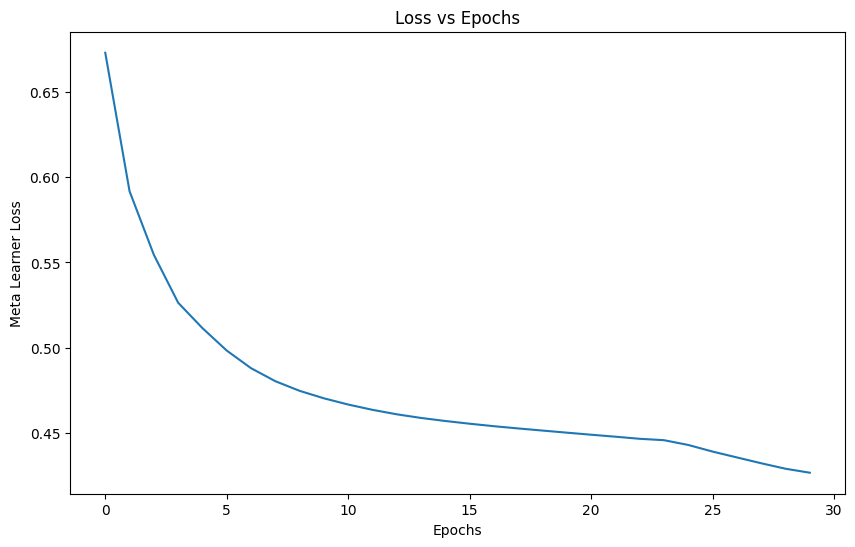

In [ ]:
maml2 = V1_Predictor2()
Losses2 = maml_train2(maml2, training_set2, epochs=30, num_inner_steps=10)
plt.figure(figsize=(10,6))
plt.xlabel('Epochs')
plt.ylabel('Meta Learner Loss')
plt.title('Loss vs Epochs')
plt.plot(Losses2)
plt.show()

In [22]:
Losses2[-1]

NameError: name 'Losses2' is not defined

In [ ]:
maml2.output_units

76

### Testing the MAML Model

In [ ]:
def test_maml2(meta_model, test_task):

    # Inner loop: Adaptation on the test task
    print(test_task.batch_size)
    num_inner_steps = 15
    optimizer = tf.keras.optimizers.Adam(0.0001)
    # Sample a batch of data from the test task
    x_train, y_train = test_task.x_ft, test_task.y_ft
    x_train = tf.expand_dims(x_train, axis=3)
    for inner_step in range(num_inner_steps):

        # Compute the loss on the batch
        with tf.GradientTape() as inner_tape:
            inner_loss = compute_loss2(meta_model, x_train, y_train, test_task.n_neurons)
        inner_gradients = inner_tape.gradient(inner_loss, meta_model.trainable_variables)

        # Update the inner model parameters
        optimizer.apply_gradients(zip(inner_gradients, meta_model.trainable_variables))

    # Evaluate the adapted model on the test set of the task
    x_test, y_test = test_task.x_test, test_task.y_test
    x_test = tf.expand_dims(x_test, axis=3)
    test_loss = compute_loss(meta_model, x_test, y_test)

    # Print or return the evaluation results
    print("Test Loss:", tf.reduce_mean(test_loss).numpy())

# Test the trained MAML model on the new task
test_maml2(maml2, test_task2)

10
Test Loss: 0.368008844747428


### Plotting Actual vs Predicted Activations

In [ ]:
X = data["images"]/255.0
y = data["activity"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
y_train.shape
X10 = data10["images"]/ 255.0
y10 = data10["activity"]
X_train10, X_test10, y_train10, y_test10 = train_test_split(X10,y10,test_size=0.2, random_state=42)


# Defining the CNN model
model4 = tf.keras.Sequential()

# Adding the convolutional layers
model4.add(layers.Input(shape=(33, 33, 1)))
model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model4.add(layers.Flatten())

# Adding the fully connected layers
model4.add(layers.Dense(320, activation='relu'))
model4.add(tf.keras.layers.Dense(y.shape[1], activation='linear'))
# Compiling the model
model4.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
history = model4.fit(X_train, y_train,
                    epochs=80,
                    validation_data=(X_test, y_test))

In [ ]:
# Fine-Tuning the Model
## Defining the CNN model
model5 = tf.keras.Sequential()

# Adding the convolutional layers
model5.add(layers.Input(shape=(33, 33, 1)))
model5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model5.add(layers.Flatten())

# Adding the fully connected layers
model5.add(layers.Dense(320, activation='relu'))
model5.add(tf.keras.layers.Dense(data10["activity"].shape[1], activation='relu'))

# Compiling the model
model5.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
# Copying the trained model's weights into the new model's
model5.set_weights(model4.get_weights()[:-4]+model5.get_weights()[4:])

# Freezing all the layers except for the last one
for layer in model5.layers[:-2]:
    layer.trainable = False

#Compiling the model
model5.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

# Generate shuffled indices
shuffled_indices = np.random.permutation(len(X10))

# Shuffle both X and y using the shuffled indices
X10_shuffled = X10[shuffled_indices]
y10_shuffled = y10[shuffled_indices]
X10 = X10_shuffled
y10 = y10_shuffled
X_train10 = X10[:10]
X_test10 = X10[10:]
y_train10 = y10[:10]
y_test10 = y10[10:]


In [ ]:
history = model5.fit(X_train10, y_train10,
                    epochs=15,
                    validation_data=(X_test10, y_test10))

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 0.4692 - mse: 0.4692 - val_loss: 0.4489 - val_mse: 0.4489
Epoch 2/15
1/1 [==============================] - 0s 119ms/step - loss: 0.3420 - mse: 0.3420 - val_loss: 0.3624 - val_mse: 0.3624
Epoch 3/15
1/1 [==============================] - 0s 104ms/step - loss: 0.2741 - mse: 0.2741 - val_loss: 0.3234 - val_mse: 0.3234
Epoch 4/15
1/1 [==============================] - 0s 224ms/step - loss: 0.2446 - mse: 0.2446 - val_loss: 0.3069 - val_mse: 0.3069
Epoch 5/15
1/1 [==============================] - 0s 193ms/step - loss: 0.2269 - mse: 0.2269 - val_loss: 0.3006 - val_mse: 0.3006
Epoch 6/15
1/1 [==============================] - 0s 76ms/step - loss: 0.2115 - mse: 0.2115 - val_loss: 0.2975 - val_mse: 0.2975
Epoch 7/15
1/1 [==============================] - 0s 71ms/step - loss: 0.1959 - mse: 0.1959 - val_loss: 0.2938 - val_mse: 0.2938
Epoch 8/15
1/1 [==============================] - 0s 102ms/step - loss: 0.1811 - mse: 0.1811 - 

9/9 [==============================] - 0s 3ms/step


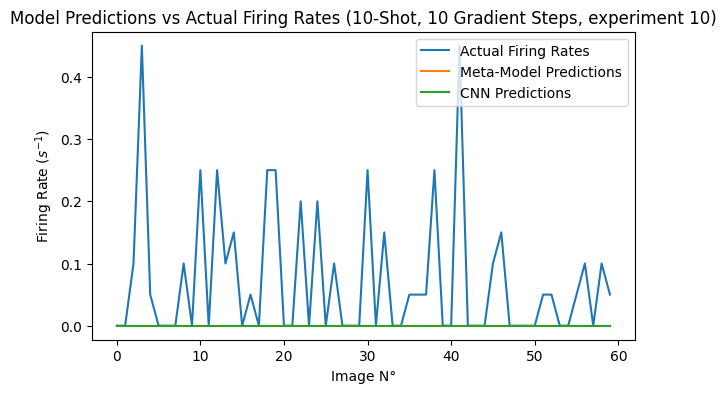

9/9 [==============================] - 0s 3ms/step


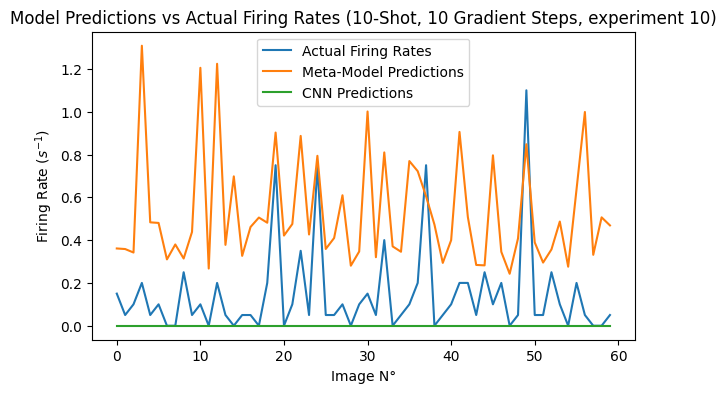

9/9 [==============================] - 0s 3ms/step


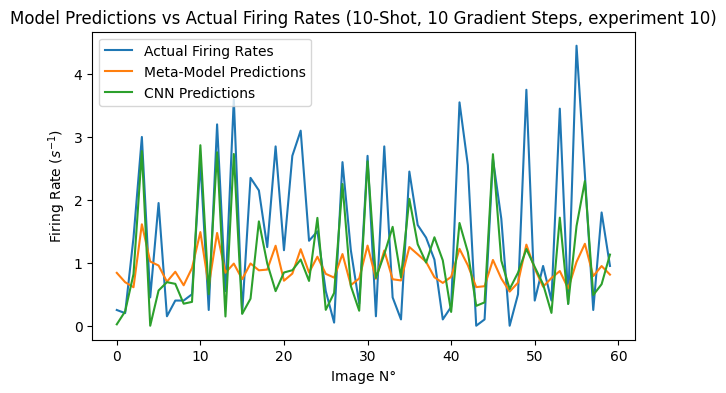

9/9 [==============================] - 0s 3ms/step


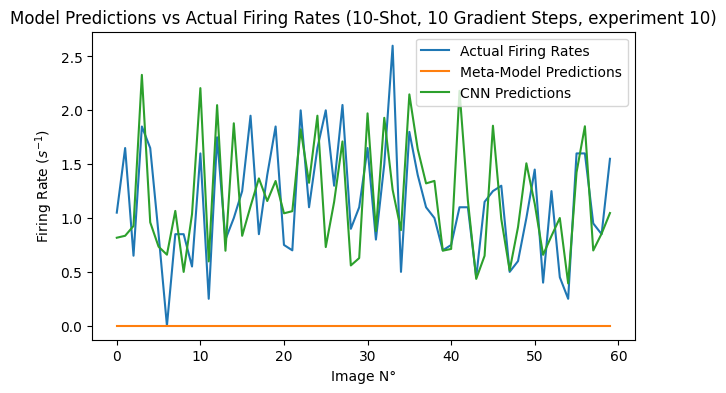

9/9 [==============================] - 0s 2ms/step


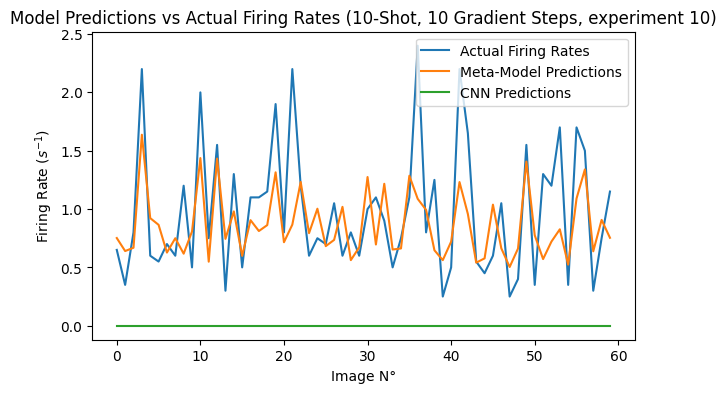

In [ ]:
for i in range(5):
    index = np.random.choice(range(test_task2.y_test.shape[1]))
    xt = np.expand_dims(test_task2.x_test, axis=3)
    yt = test_task2.y_test
    y_preds = maml2.predict(xt)[:,i]
    y_preds_cnn = model5.predict(xt)[:,i]
    plt.figure(figsize=(7,4))
    # Plotting the actual activations
    plt.plot(range(60), yt[:60,i], label='Actual Firing Rates')

    # Plotting the predicted activations for the meta-model
    plt.plot(range(60), y_preds[:60], label='Meta-Model Predictions')

    # Plotting the predicted activations for the CNN
    plt.plot(range(60), y_preds_cnn[:60], label='CNN Predictions')

    plt.xlabel('Image N°')
    plt.ylabel('Firing Rate ($s^{-1}$)')
    plt.title('Model Predictions vs Actual Firing Rates (10-Shot, 10 Gradient Steps, experiment 10)')
    plt.legend()

    plt.show()

### Correlation

In [ ]:
def compute_correlation(y_preds, y):
    corrs = []
    for i in range(y.shape[1]):
        corrs.append(np.corrcoef(y_preds[:,i], y[:,i])[0, 1])
    print(len(corrs))
    return np.nanmean(corrs)
x_test = np.expand_dims(test_task2.x_test, axis=3)
y_preds = model5.predict(x_test)
correlation = compute_correlation(y_preds, test_task2.y_test)
print("Correlation coefficient:", correlation)

9/9 [==============================] - 0s 3ms/step
76
Correlation coefficient: 0.2632675673432888


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Predicting V1 Neural Responses Across Experimental Subjects

### Meta-Model Class

In [5]:
# Generic CNN predictor class
class V1_Predictor3(tf.keras.Model):
    def __init__(self, output_units=195):
        super().__init__()
        self.output_units = output_units
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu',)
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(200, activation='relu')
        self.out = layers.Dense(output_units, activation='relu')

    def forward(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

    def call(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.out(x)
        return output

### Defining Suject Classes

In [6]:
class Train_Subject:
    def __init__(self, x_train, y_train, x_test, y_test, n_neurons, batch_size=9):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.n_neurons = n_neurons
        self.batch_size = batch_size

    def train_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_train)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_train, batch_indices)
        batch_y = tf.gather(self.y_train, batch_indices)
        #return batch_x, batch_y
        return tf.expand_dims(self.x_train, axis=3), self.y_train

    def test_batch(self):
        indices = tf.random.shuffle(tf.range(len(self.x_test)))
        batch_indices = indices[:self.batch_size]
        batch_x = tf.gather(self.x_test, batch_indices)
        batch_y = tf.gather(self.y_test, batch_indices)
        #return batch_x, batch_y
        return tf.expand_dims(self.x_test, axis=3), self.y_test
        #return self.x_test, self.y_test

class Test_Subject:
    def __init__(self, x_ft, y_ft, x_test, y_test, n_neurons, batch_size=9):
        self.x_ft = x_ft
        self.y_ft = y_ft
        self.x_test = x_test
        self.y_test = y_test
        self.n_neurons = n_neurons
        self.batch_size = batch_size

### Useful Functions and Data Preparation

In [101]:
def concat(data_list):
    """
    Function to bundle all the data from the first 9 experimental sessions into a single
    dictionary. The shape of the activations matrix will be (270,316)
    """
    images = data_list[0]["images"]
    activity = data_list[0]["activity"]
    for data_dict in data_list[1:]:
        activity = np.concatenate((activity, data_dict["activity"]), axis=1)
    return dict({"images":images, "activity":activity})

def pad(vector, length): # Number of neurons for subject 2
    padded_vector = []
    m = len(vector)
    for i in range(length):
        padded_vector.append(vector[i%m])
    return np.array(padded_vector)

def pad_vectors(vectors, length=195):
    padded_vectors = []
    for vector in vectors:
        padded_vectors.append(pad(vector,length))
    return np.abs(padded_vectors)

def create_train_subject(data_dict):
    X = data_dict["images"]/255.0
    y = data_dict["activity"]
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
    train_subject = Train_Subject(X_train, y_train, X_test, y_test, n_neurons=data_dict['activity'].shape[1])
    return train_subject

def create_test_subject(data_dict, bs=5):
    X = data_dict["images"]/255.0
    y = data_dict["activity"]
    # Generate shuffled indices
    shuffled_indices = np.random.permutation(len(X))

    # Shuffle both X and y using the shuffled indices
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    X = X_shuffled
    y = y_shuffled
    x_ft = X[:bs]
    y_ft = y[:bs]
    x_test = X[bs:]
    y_test = y[bs:]
    test_subject = Test_Subject(x_ft,y_ft,x_test,y_test, n_neurons=data_dict['activity'].shape[1], batch_size=bs)
    return test_subject
s2, s3 = concat([data2,data3,data4,data5,data6,data7]), concat([data8, data9, data10])
train_subjects = [create_train_subject(s2), create_train_subject(s3)]
#test_subject = create_test_subject(concat([data8, data9, data10]))
test_subject = create_test_subject(data1)

In [102]:
test_subject.y_test.shape[1]

26

In [ ]:
def Copy_model1(model, n_neurons):
    copied_model = V1_Predictor3(output_units=n_neurons)
    init  = tf.constant(1.0, shape=(1,33,33,1))
    copied_model(init)
    copied_model.set_weights(model.get_weights())
    return copied_model

def Copy_model2(model, n_neurons, x):

    copied_model = V1_Predictor3(output_units=n_neurons)
    copied_model(x)
    copied_model.set_weights(model.get_weights()[:-2]+copied_model.get_weights()[6:])

    return copied_model

def Copy_model3(model):
    init  = tf.constant(1.0, shape=(1,33,33,1))
    copied_model = V1_Predictor3()
    copied_model.forward(init)
    copied_model.set_weights(model.get_weights())

    return copied_model

In [9]:
def copy_model(model, x):

    copied_model = tf.keras.Sequential([
    layers.Input(shape=(33, 33,1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten()
])
    copied_model(x)
    copied_model.set_weights(model.get_weights())

    return copied_model

In [10]:
for subject in [train_subjects[0], train_subjects[1], test_subject]:
    print(subject.y_test.shape[1])

26
195
171


In [11]:
for subject in [train_subjects[0], train_subjects[1], test_subject]:
    print(subject.n_neurons)

26
195
171


### MAML Training

In [38]:
def maml_train3(model, dataset, epochs, num_inner_steps, inner_lr=0.0001):
    losses = []  # List to store the losses for plotting

    # Best values: inner_lr=0.0001 and outer_lr =0.001
    outer_lr = 0.0005
    optimizer = tf.keras.optimizers.Adam(outer_lr)
    # Meta-training loop
    init  = tf.constant(1.0, shape=(1,33,33,1))
    model(init)
    for epoch in range(epochs):
        meta_losses = []  # List to store the meta-losses for the current meta-iteration

        # Iterate over training tasks
        sum_test_losses = 0.0
        for subject in dataset:

            # Create a copy of the meta-model for the inner loop
            inner_model = tf.keras.Sequential([
                copy_model(model, init),
                layers.Flatten(),
                layers.Dense(subject.n_neurons+4, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(subject.n_neurons, activation='relu')
            ])
            # Sample a batch of data from the task
            x_train, y_train = subject.train_batch()
            # Inner loop: Adaptation on the task
            for _ in range(num_inner_steps):
                #
                # Compute the loss on the batch
                inner_optimizer = tf.keras.optimizers.Adam(inner_lr)
                with tf.GradientTape() as inner_tape:
                    train_loss = compute_loss(inner_model, x_train, y_train)
                inner_gradients = inner_tape.gradient(train_loss, inner_model.trainable_variables)
                inner_optimizer.apply_gradients(zip(inner_gradients, inner_model.trainable_variables))
                k = 0
                ### Upating weights only for the trainable layers
                """
                for j in range(len(inner_model.layers)):
                    if len(inner_model.layers[j].get_weights()) > 0:
                        weights = inner_model.layers[j].get_weights()
                        print("Shape of weights[0]:", weights[0].shape)
                        print("Shape of tf.multiply(inner_lr, inner_gradients[k]):", tf.multiply(inner_lr, inner_gradients[k]).shape)
                        weights[0] = tf.subtract(weights[0], tf.multiply(inner_lr, inner_gradients[k]))
                        weights[1] = tf.subtract(weights[1], tf.multiply(inner_lr, inner_gradients[k+1]))
                        inner_model.layers[j].set_weights(weights)
                        k += 2
                        """
                
            x_test, y_test = subject.test_batch()
            with tf.GradientTape() as meta_tape:
                test_loss = compute_loss(inner_model, x_test, y_test)
                # Accumulate test loss
                sum_test_losses += test_loss

            # Compute the gradients for the meta-model update
            meta_gradients = meta_tape.gradient(sum_test_losses, inner_model.trainable_variables[:4])

            # Apply the meta-gradients to update the meta-model
            optimizer.apply_gradients(zip(meta_gradients, model.trainable_variables))
            meta_losses.append(test_loss)

        # Calculate the mean loss for the meta-iteration
        mean_loss = tf.reduce_mean(meta_losses)
        losses.append(mean_loss)
        print("Iteration {} - Loss: {:.2f}".format(epoch+1, losses[-1].numpy()))
        #Early stopping, patience = 3 epochs
        if len(losses) > 3:
          if all(losses[-1] >= loss for loss in losses[-4:-1]):
              print("No improvement in 3 epochs, stopping training.")
              break

        # Perform any desired evaluation or logging
    return losses

In [39]:
maml3 = tf.keras.Sequential([
    layers.Input(shape=(33, 33,1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
])

Iteration 1 - Loss: 0.36
Iteration 2 - Loss: 0.34
Iteration 3 - Loss: 0.34
Iteration 4 - Loss: 0.35
Iteration 5 - Loss: 0.33
Iteration 6 - Loss: 0.35
Iteration 7 - Loss: 0.35
No improvement in 3 epochs, stopping training.


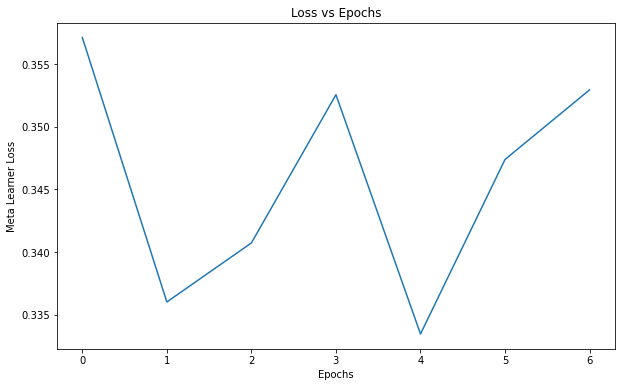

In [53]:
Losses3 = maml_train3(maml3, train_subjects, epochs=20, num_inner_steps=10)
plt.figure(figsize=(10,6))
plt.xlabel('Epochs')
plt.ylabel('Meta Learner Loss')
plt.title('Loss vs Epochs')
plt.plot(Losses3)
plt.show()

In [23]:
Losses3[-1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.35377708786331347>

### MAML Testing

In [46]:
test_model = tf.keras.Sequential()

test_model.add(layers.Input(shape=(33, 33, 1)))
test_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
test_model.add(layers.MaxPooling2D((2, 2)))
test_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
test_model.add(layers.MaxPooling2D((2, 2)))
test_model.add(layers.Flatten())
test_model.add(layers.Dense(test_subject.y_test.shape[1]+4, activation='relu'))
test_model.add(tf.keras.layers.Dense(test_subject.y_test.shape[1], activation='relu'))
test_model.set_weights(maml3.get_weights()+test_model.get_weights()[4:])
test_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [54]:
print("Batch size:", test_subject.batch_size)
test_model.fit(test_subject.x_ft, test_subject.y_ft,
                    epochs=10,
                    batch_size=1
                    )

Batch size: 5
Epoch 1/10


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1271 - mse: 0.1271
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1247 - mse: 0.1247
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1230 - mse: 0.1230
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1220 - mse: 0.1220
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1210 - mse: 0.1210
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1199 - mse: 0.1199
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1188 - mse: 0.1188
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1177 - mse: 0.1177
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1167 - mse: 0.1167
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1156 - mse: 0.1156


### CTCNN

In [103]:
def concat(data_list):
    """
    Function to bundle all the data from the first 9 experimental sessions into a single
    dictionary. The shape of the activations matrix will be (270,316)
    """
    images = data_list[0]["images"]
    activity = data_list[0]["activity"]
    for data_dict in data_list[1:]:
        activity = np.concatenate((activity, data_dict["activity"]), axis=1)
    return dict({"images":images, "activity":activity})

data_list = [data2, data3, data4, data5, data6, data7, data8, data9, data10]
subj23 = concat(data_list)

In [104]:
X = subj23["images"]/255.0
y = subj23["activity"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
y_train.shape
X1 = data1["images"]/ 255.0
y1 = data1["activity"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.2, random_state=42)


# Defining the CNN model
model4 = tf.keras.Sequential()

# Adding the convolutional layers
model4.add(layers.Input(shape=(33, 33, 1)))
model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model4.add(layers.Flatten())

# Adding the fully connected layers
model4.add(layers.Dense(400, activation='relu'))
model4.add(tf.keras.layers.Dense(y.shape[1], activation='relu'))
# Compiling the model
model4.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
history = model4.fit(X_train, y_train,
                    epochs=70,
                    validation_data=(X_test, y_test))

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.6360 - mse: 0.6360 - val_loss: 0.4024 - val_mse: 0.4024
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4043 - mse: 0.4043 - val_loss: 0.3525 - val_mse: 0.3525
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.3507 - mse: 0.3507 - val_loss: 0.3031 - val_mse: 0.3031
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3125 - mse: 0.3125 - val_loss: 0.2915 - val_mse: 0.2915
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3001 - mse: 0.3001 - val_loss: 0.2832 - val_mse: 0.2832
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2908 - mse: 0.2908 - val_loss: 0.2702 - val_mse: 0.2702
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.2606 - val_mse: 0.2606
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2688 - mse: 0.2688 - val_loss: 0.2503 - val_mse: 0.2503
Epoch 9/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.2562 - mse: 0.2562 -

In [106]:
# Fine-Tuning the Model
## Defining the CNN model
model1 = tf.keras.Sequential()

# Adding the convolutional layers
model1.add(layers.Input(shape=(33, 33, 1)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

# Flattening the output from the previous layer
model1.add(layers.Flatten())

# Adding the fully connected layers
model1.add(layers.Dense(test_subject.y_test.shape[1]+4, activation='relu'))
model1.add(tf.keras.layers.Dense(test_subject.y_test.shape[1], activation='relu'))


# Copying the trained model's weights into the new model's
model1.set_weights(model4.get_weights()[:-4]+model1.get_weights()[4:])

# Freezing all the layers except for the last one
#for layer in model5.layers[:-2]:
    #layer.trainable = False

#Compiling the model
model1.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [108]:
print("Batch size:", test_subject.batch_size)
model1.fit(test_subject.x_ft, test_subject.y_ft,
                    epochs=5,
                    batch_size=1
                    )

Batch size: 5
Epoch 1/5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1828 - mse: 0.1828
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1347 - mse: 0.1347 
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0884 - mse: 0.0884 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0718 - mse: 0.0718 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0589 - mse: 0.0589 


### Plotting Prediction vs Measurements

In [ ]:
for i in range(5):
    index = np.random.choice(range(test_subject.y_test.shape[1]))
    xt = np.expand_dims(test_subject.x_test, axis=3)
    yt = test_subject.y_test
    y_preds = test_model.predict(xt)[:,i]
    y_preds_cnn = model1.predict(xt)[:,i]
    plt.figure(figsize=(7,4))
    # Plotting the actual activations
    plt.plot(range(60), yt[:60,i], label='Actual Firing Rates')

    # Plotting the predicted activations for the meta-model
    plt.plot(range(60), y_preds[:60], label='Meta-Model Predictions')

    # Plotting the predicted activations for the CNN
    plt.plot(range(60), y_preds_cnn[:60], label='CNN Predictions')

    plt.xlabel('Image N°')
    plt.ylabel('Firing Rate ($s^{-1}$)')
    plt.title('Model Predictions vs Actual Firing Rates (10-Shot, 10 Gradient Steps, experiment 10)')
    plt.legend()

    plt.show()

### Correlation

In [109]:
def compute_correlation(y_preds, y):
    corrs = []
    for i in range(y.shape[1]):
        corrs.append(np.corrcoef(y_preds[:,i], y[:,i])[0, 1])
    print(len(corrs))
    return np.nanmean(corrs)
x_test = np.expand_dims(test_subject.x_test, axis=3)
y_preds = model1.predict(x_test)
correlation = compute_correlation(y_preds, test_subject.y_test)
print("Correlation coefficient:", correlation)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
26
Correlation coefficient: 0.235250692438237
